In [1]:
import os
import re
import warnings

warnings.filterwarnings("ignore")

In [2]:
import altair as alt
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import pysentiment2 as ps
import seaborn as sns
import spacy
from dotenv import find_dotenv, load_dotenv
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from rich import print
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import pipeline

from sentibignomics import senti_bignomics

%load_ext rich


load_dotenv(find_dotenv())


True

In [3]:
nltk.download("stopwords")
nltk.download("vader_lexicon")

[nltk_data] Downloading package stopwords to C:\Users\Lakshya
[nltk_data]     Agarwal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to C:\Users\Lakshya
[nltk_data]     Agarwal\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

### Load documents


In [4]:
documents_list = os.listdir("./extracted/")

docs = {
    doc.split("_")[0]: open(f"./extracted/{doc}", "r").read()
    for doc in documents_list
    if doc.endswith(".txt")
}

### Preprocess documents


In [5]:
print(docs["AAPL"])

Item 7. Management&#8217;s Discussion and Analysis of Financial Condition and Results of Operations 

The following discussion should be read in conjunction with the consolidated financial statements and accompanying 
notes included in Part II, Item 8 of this Form 10-K. This section of this Form 10-K generally discusses 2020 and 
2019 items and year-to-year comparisons between 2020 and 2019. Discussions of 2018 items and year-to-year 
comparisons between 2019 and 2018 that are not included in this Form 10-K can be found in &#8220;Management&#8217;s
Discussion and Analysis of Financial Condition and Results of Operations&#8221; in Part II, Item 7 of the 
Company&#8217;s Annual Report on Form 10-K for the fiscal year ended September 28, 2019. 

Fiscal Year Highlights 

COVID-19 Update 

COVID-19 has spread rapidly throughout the world, prompting governments and businesses to take unprecedented 
measures in response. Such measures have included restrictions on travel and business operations, temporary 
closures of businesses, and quarantines and shelter-in-place orders. The COVID-19 pandemic has significantly 
curtailed global economic activity and caused significant volatility and disruption in global financial markets. 
The COVID-19 pandemic and the measures taken by many countries in response have adversely affected and could in the
future materially adversely impact the Company&#8217;s business, results of operations, financial condition and 
stock price. 

During 2020, aspects of the Company&#8217;s business were adversely affected by the COVID-19 pandemic, with many of
the Company&#8217;s retail stores, as well as channel partner points of sale, temporarily closed at various times, 
and the vast majority of the Company&#8217;s employees working remotely. The Company has reopened some of its 
offices and the majority of its retail stores, subject to operating restrictions to protect public health and the 
health and safety of employees and customers, and it continues to work on safely re-opening the remainder of its 
offices and retail stores, subject to local rules and regulations. 

The full extent of the future impact of the COVID-19 pandemic on the Company&#8217;s operational and financial 
performance is currently uncertain and will depend on many factors outside the Company&#8217;s control, including, 
without limitation, the timing, extent, trajectory and duration of the pandemic, the development and availability 
of effective treatments and vaccines, the imposition of protective public safety measures, and the impact of the 
pandemic on the global economy and demand for consumer products. Refer to Part I, Item 1A of this Form 10-K under 
the heading &#8220;Risk Factors,&#8221; for more information. 

The Company believes its existing balances of cash, cash equivalents and marketable securities, along with 
commercial paper and other short-term liquidity arrangements, will be sufficient to satisfy its working capital 
needs, capital asset purchases, dividends, share repurchases, debt repayments and other liquidity requirements 
associated with its existing operations. 

Fiscal 2020 Highlights 

Total net sales increased 6% or $14.3 billion during 2020 compared to 2019, primarily driven by higher net sales of
Services and Wearables, Home and Accessories. The weakness in foreign currencies had an unfavorable impact on net 
sales during 2020. 

In April 2020, the Company announced an increase to its current share repurchase program authorization from $175 
billion to $225 billion and raised its quarterly dividend from $0.1925 to $0.205 per share beginning in May 2020. 
During 2020, the Company repurchased $72.5 billion of its common stock and paid dividends and dividend equivalents 
of $14.1 billion. 

On August 28, 2020, the Company effected a four-for-one stock split to shareholders of record as of August 24, 
2020. All share, RSU and per share or per RSU information has been retroactively adjusted to reflect the stock

In [6]:
doc_lengths = {k: len(v) for k, v in docs.items()}

print([(k, v) for k, v in doc_lengths.items() if v < 1000])

docs_to_remove = [k for k, v in doc_lengths.items() if v < 1000]


[
    ('CVX', 293),
    ('C', 0),
    ('DE', 251),
    ('ETN', 269),
    ('GE', 106),
    ('IBM', 238),
    ('JPM', 431),
    ('MA', 0),
    ('PGR', 250),
    ('WFC', 324),
    ('XOM', 288)
]

The above tickers do not have relevant content in their MD&A, possibly due to cross-reference to other sections or unavailability of the documents. We drop these tickers from the list.


In [7]:
for key in docs_to_remove:
    docs.pop(key, None)

## Preprocessing


In [8]:
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))
stop_words.update(["table_end", "table_start"])


class Tokenizer:
    def __init__(self):
        self.nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words("english"))
        self.stop_words.update(["table_end", "table_start"])

    def tokenize(self, text):
        # Clean text
        text = text.lower()  # Lowercase
        text = re.sub(
            r"\$\d+(\.\d+)?(m| million| billion)?", " ", text
        )  # Remove dollar amounts
        text = re.sub(r"\d+(\.\d+)?%", " ", text)  # Remove percentages
        text = re.sub(r"\b\d+(\.\d+)?\b", " ", text)  # Remove standalone numbers
        text = re.sub(r"\s+", " ", text).strip()  # Remove extra spaces
        text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation

        # Tokenize and remove stopwords
        tokens = [
            word for word in nltk.word_tokenize(text) if word not in self.stop_words
        ]

        # Lemmatize
        lemmatized = [self.lemmatizer.lemmatize(token) for token in tokens]

        return lemmatized

We define the preprocessing pipeline as follows:
- Convert to lowercase
- Remove mention of dollar amounts
- Remove percentages
- Remove standalone numbers
- Remove extra whitespaces and punctuations
- Tokenize by word and remove stopwords
- Lemmatize words using WordNetLemmatizer

Since the focus is on a qualitative analysis of the MD&A, we remove dollar amounts, percenages and numbers as they are not relevant for the analysis. We also remove stopwords and lemmatize the words to reduce the dimensionality of the data and to focus on the content of the documents.

In [9]:
tokenizer = Tokenizer()


def preprocess_text(text):
    return " ".join(tokenizer.tokenize(text))


### TF-IDF


In [10]:
tf_idf_vectorizer = TfidfVectorizer(
    max_df=0.95,
    min_df=5,
    max_features=2000,
    preprocessor=preprocess_text,
    strip_accents="unicode",
)

tf_idf = tf_idf_vectorizer.fit_transform(docs.values())


In [11]:
tf_idf_df = pd.DataFrame(
    tf_idf.todense(),
    columns=tf_idf_vectorizer.get_feature_names_out(),
    index=docs.keys(),
)

tf_idf_df.loc["0_DOC_FREQ"] = (tf_idf_df > 0).sum()
tf_idf_df.sort_index().round(2)


,1a,3d,5g,aa,ability,able,absence,absolute,aca,accelerate,...,writeoff,written,yearend,yearoveryear,yeartoyear,yen,yet,yield,york,zero
0_DOC_FREQ,59.00,8.00,7.00,17.00,83.00,54.00,25.00,15.0,6.0,30.0,...,11.00,33.00,18.00,42.00,19.00,21.00,44.00,45.00,16.0,19.00
AAPL,0.03,0.00,0.00,0.00,0.00,0.00,0.02,0.0,0.0,0.0,...,0.00,0.00,0.00,0.05,0.05,0.02,0.02,0.00,0.0,0.00
ABBV,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.01,0.0,0.01
ABT,0.01,0.01,0.00,0.00,0.01,0.00,0.00,0.0,0.0,0.0,...,0.00,0.01,0.00,0.01,0.00,0.00,0.00,0.00,0.0,0.01
ACN,0.01,0.00,0.00,0.00,0.02,0.00,0.00,0.0,0.0,0.0,...,0.00,0.00,0.00,0.01,0.00,0.01,0.00,0.00,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UPS,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.0,0.0,0.0,...,0.00,0.01,0.00,0.00,0.00,0.00,0.01,0.03,0.0,0.00
V,0.01,0.00,0.00,0.01,0.00,0.01,0.02,0.0,0.0,0.0,...,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.0,0.00
VRTX,0.00,0.00,0.00,0.00,0.01,0.02,0.00,0.0,0.0,0.0,...,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00
VZ,0.00,0.00,0.11,0.00,0.01,0.00,0.00,0.0,0.0,0.0,...,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.01,0.0,0.00


In [12]:
print(tf_idf_df.T.sort_values("0_DOC_FREQ", ascending=False).head(50).index)
tf_idf_df.drop("0_DOC_FREQ", inplace=True)

Index(['contract', 'exchange', 'investing', 'determine', 'prior', 'driven',
       'ended', 'development', 'charge', 'circumstance', 'strategy', 'return',
       'order', 'expect', 'one', 'uncertainty', 'fair', 'regarding', 'measure',
       'corporate', 'historical', 'december', 'ability', 'likely', 'differ',
       'expenditure', 'annual', 'see', 'technology', 'end', 'demand',
       'however', 'working', 'margin', 'equity', 'event', 'risk', 'using',
       'source', 'carrying', 'experience', 'resulting', 'require', 'currently',
       'administrative', 'applicable', 'assessment', 'continued', 'authority',
       'settlement'],
      dtype='object')

In [13]:
top_tfidf = (
    (
        tf_idf_df.stack()
        .reset_index()
        .rename(
            columns={
                0: "tfidf",
                "level_0": "document",
                "level_1": "term",
                "level_2": "term",
            }
        )
    )
    .sort_values(by=["document", "tfidf"], ascending=[True, False])
    .groupby(["document"])
    .head(10)
)

top_tfidf

,document,term,tfidf
118,AAPL,apple,0.375355
15,AAPL,accessory,0.301989
1652,AAPL,september,0.207151
1082,AAPL,marketable,0.164501
806,AAPL,gross,0.154029
...,...,...,...
174979,WMT,january,0.140389
175639,WMT,segment,0.118282
174167,WMT,average,0.107986
174767,WMT,free,0.105298


In [14]:
# adding a little randomness to break ties in term ranking
top_tfidf_plusRand = top_tfidf.copy()
top_tfidf_plusRand["tfidf"] = (
    top_tfidf_plusRand["tfidf"] + np.random.rand(top_tfidf.shape[0]) * 0.0001
)

base = (
    alt.Chart(top_tfidf_plusRand)
    .encode(x="rank:O", y="document:N")
    .transform_window(
        rank="rank()",
        sort=[alt.SortField("tfidf", order="descending")],
        groupby=["document"],
    )
)

heatmap = base.mark_rect().encode(color="tfidf:Q")

text = base.mark_text(baseline="middle").encode(
    text="term:N",
    color=alt.condition(
        alt.datum.tfidf >= 0.23, alt.value("white"), alt.value("black")
    ),
)

(heatmap + text).properties(width=1000)


alt.LayerChart(...)

The above shows the top 10 words with the highest TF-IDF scores for each document. We can see that the words are relevant to the content and industry of each stock ticker. For example, Boeing Airlines (BA) has words like "aircraft", "airline", "contract", while Tesla (TSLA) has words like "automotive", "energy", "vehicle".

This indicates that the TF-IDF scores are capturing the relevant content of the documents.

## Sentiment analysis


To perform sentiment analysis using the lexicons, we tokenize each document into sentences, apply the preprocessing pipeline, and then calculate the sentiment scores for each sentence using the lexicons.

### Loughran and McDonald Financial Sentiment Dictionaries


In [15]:
lm = ps.LM(tokenizer=tokenizer)

LM_res = []

for k, v in docs.items():
    for sent in nltk.sent_tokenize(v):
        scores = lm.get_score(lm.tokenize(sent))
        LM_res.append(
            {
                "Document": k,
                "Sentence": sent,
                "LM_Positive": scores["Positive"],
                "LM_Negative": scores["Negative"],
                "LM_Polarity": scores["Polarity"],
                "LM_Subjectivity": scores["Subjectivity"],
            }
        )


print("Processed using LM financial dictionary")
LM_res = pd.DataFrame(LM_res)


Processed using LM financial dictionary

### Using VADER


In [16]:
VADER_res = []
vader = SentimentIntensityAnalyzer()


for k, v in docs.items():
    for sent in nltk.sent_tokenize(v):
        scores = vader.polarity_scores(preprocess_text(sent))

        VADER_res.append(
            {
                "Document": k,
                "Sentence": sent,
                "VADER_Negative": scores["neg"],
                "VADER_Neutral": scores["neu"],
                "VADER_Positive": scores["pos"],
                "VADER_Compound": scores["compound"],
            }
        )

print("Processed using VADER")
VADER_res = pd.DataFrame(VADER_res)

Processed using VADER

### Using SentiBigNomics

Consoli, S., Barbaglia, L., & Manzan, S. (2022). Fine-grained, aspect-based sentiment analysis on economic and financial lexicon. Knowledge-Based Systems, 247, 108781. https://doi.org/10.1016/j.knosys.2022.108781

In [17]:
SBN_res = []
sbn_vader = SentimentIntensityAnalyzer()
sbn_vader.lexicon.update(senti_bignomics)

for k, v in docs.items():
    for sent in nltk.sent_tokenize(v):
        scores = sbn_vader.polarity_scores(preprocess_text(sent))

        SBN_res.append(
            {
                "Document": k,
                "Sentence": sent,
                "SBN_VADER_Negative": scores["neg"],
                "SBN_VADER_Neutral": scores["neu"],
                "SBN_VADER_Positive": scores["pos"],
                "SBN_VADER_Compound": scores["compound"],
            }
        )

print("Processed using SentiBigNomics")

SBN_res = pd.DataFrame(SBN_res)


Processed using SentiBigNomics

### Using pre-trained model [FinBERT](https://huggingface.co/ProsusAI/finbert)


In [18]:
pipe = pipeline("sentiment-analysis", model="ProsusAI/finbert", device=0)

In [19]:
finbert_results = []

for ticker, doc in docs.items():
    print(f"Processing {ticker} using FinBERT")
    for sent in nltk.sent_tokenize(doc):
        sentiment = pipe(
            sent, padding=True, truncation=True, max_length=512, top_k=None
        )

        finbert_results.append(
            {"Ticker": ticker, "Sentence": sent, "Sentiment": sentiment}
        )


print("Processed using FinBERT")

Processing AAPL using FinBERT

Processing ABBV using FinBERT

Processing ABT using FinBERT

Processing ACN using FinBERT

Processing ADBE using FinBERT

Processing ADI using FinBERT

Processing ADP using FinBERT

Processing AMAT using FinBERT

Processing AMD using FinBERT

Processing AMGN using FinBERT

Processing AMZN using FinBERT

Processing AVGO using FinBERT

Processing AXP using FinBERT

Processing BAC using FinBERT

Processing BA using FinBERT

Processing BKNG using FinBERT

Processing BLK using FinBERT

Processing BMY using FinBERT

Processing BRK-B using FinBERT

Processing BSX using FinBERT

Processing BX using FinBERT

Processing CAT using FinBERT

Processing CB using FinBERT

Processing CI using FinBERT

Processing CMCSA using FinBERT

Processing COP using FinBERT

Processing COST using FinBERT

Processing CRM using FinBERT

Processing CSCO using FinBERT

Processing CVS using FinBERT

Processing DHR using FinBERT

Processing DIS using FinBERT

Processing ELV using FinBERT

Processing GILD using FinBERT

Processing GOOGL using FinBERT

Processing GS using FinBERT

Processing HD using FinBERT

Processing HON using FinBERT

Processing INTC using FinBERT

Processing INTU using FinBERT

Processing ISRG using FinBERT

Processing KO using FinBERT

Processing LIN using FinBERT

Processing LLY using FinBERT

Processing LMT using FinBERT

Processing LOW using FinBERT

Processing LRCX using FinBERT

Processing MCD using FinBERT

Processing MDLZ using FinBERT

Processing MDT using FinBERT

Processing META using FinBERT

Processing MMC using FinBERT

Processing MRK using FinBERT

Processing MSFT using FinBERT

Processing MS using FinBERT

Processing MU using FinBERT

Processing NEE using FinBERT

Processing NFLX using FinBERT

Processing NKE using FinBERT

Processing NOW using FinBERT

Processing NVDA using FinBERT

Processing ORCL using FinBERT

Processing PANW using FinBERT

Processing PEP using FinBERT

Processing PFE using FinBERT

Processing PG using FinBERT

Processing PLD using FinBERT

Processing PM using FinBERT

Processing QCOM using FinBERT

Processing REGN using FinBERT

Processing RTX using FinBERT

Processing SBUX using FinBERT

Processing SCHW using FinBERT

Processing SPGI using FinBERT

Processing SYK using FinBERT

Processing TJX using FinBERT

Processing TMO using FinBERT

Processing TSLA using FinBERT

Processing TXN using FinBERT

Processing T using FinBERT

Processing UBER using FinBERT

Processing UNH using FinBERT

Processing UNP using FinBERT

Processing UPS using FinBERT

Processing VRTX using FinBERT

Processing VZ using FinBERT

Processing V using FinBERT

Processing WMT using FinBERT

Processed using FinBERT

In [20]:
finbert_results_df = pd.json_normalize(
    finbert_results, record_path="Sentiment", meta=["Ticker", "Sentence"]
).pivot_table(
    values="score",
    index=["Ticker", "Sentence"],
    columns="label",
)

finbert_results_df


label                                                      negative   neutral  \
Ticker Sentence                                                                 
AAPL    Item 7.                                            0.059011  0.917935   
       (2) Wearables, Home and Accessories net sales i...  0.011777  0.933356   
       (3) Services net sales include sales from the C...  0.011173  0.942424   
       2016-13, Financial Instruments &#8211; Credit L...  0.064615  0.907286   
       Actual results may differ from these estimates,...  0.717033  0.246972   
...                                                             ...       ...   
WMT    When facts and circumstances change, we reasses...  0.029786  0.944516   
       When necessary, we record a LIFO provision for ...  0.027338  0.940747   
       While ROI is considered a non-GAAP financial me...  0.007277  0.217625   
       While fiscal 2019 included a pre-tax loss of $4...  0.054686  0.929661   
       While we are awaiting anticipated technical gui...  0.400724  0.566378   

label                                                      positive  
Ticker Sentence                                                      
AAPL    Item 7.                                            0.023054  
       (2) Wearables, Home and Accessories net sales i...  0.054867  
       (3) Services net sales include sales from the C...  0.046403  
       2016-13, Financial Instruments &#8211; Credit L...  0.028099  
       Actual results may differ from these estimates,...  0.035995  
...                                                             ...  
WMT    When facts and circumstances change, we reasses...  0.025698  
       When necessary, we record a LIFO provision for ...  0.031915  
       While ROI is considered a non-GAAP financial me...  0.775098  
       While fiscal 2019 included a pre-tax loss of $4...  0.015653  
       While we are awaiting anticipated technical gui...  0.032898  

[40156 rows x 3 columns]

In [21]:
finbert_results_df.groupby("Ticker")[['negative', 'neutral', 'positive']].agg("mean")

label,negative,neutral,positive
Ticker,,,
AAPL,0.200770,0.609698,0.189531
ABBV,0.125290,0.608638,0.266072
ABT,0.147613,0.577167,0.275220
ACN,0.214290,0.526049,0.259661
ADBE,0.112824,0.644548,0.242627
...,...,...,...
UPS,0.196942,0.507644,0.295414
V,0.179173,0.697402,0.123426
VRTX,0.138450,0.577324,0.284225


### Calculate Frequency of COVID-related Disclosure

Dutta, S., Kumar, A., Pant, P., Walsh, C., & Dutta, M. (2023). Using 10-K text to gauge COVID-related corporate disclosure. PLOS ONE, 18(3), e0283138. https://doi.org/10.1371/journal.pone.0283138

In [22]:
# list of words related to covid from paper
covid_word_list = """pandemic
epidemic
contagious
disease
infectious
coronavirus
covid
strain
outbreak
resurgence
health
crisis
"""

covid_word_list = covid_word_list.split("\n")

# getting lists of positive and negative words from VADER
positive_words = [word for word in vader.lexicon if vader.lexicon[word] > 0]
negative_words = [word for word in vader.lexicon if vader.lexicon[word] < 0]

In [23]:
# Helper function for checking if a sentence contains any word from a list
def sentence_contains_wordlist(words, wordlist):
    return any(word in wordlist for word in words)


covid_res = []

for k, v in docs.items():
    # initializing variables
    sentences = nltk.sent_tokenize(v)
    total_sentence_count = len(sentences)

    # calculating contextual and covid-related disclosure frequencies
    for sentence in sentences:
        contextual_positive_freq = 0
        contextual_negative_freq = 0
        covid_freq = 0

        tokens = tokenizer.tokenize(sentence)

        if sentence_contains_wordlist(tokens, covid_word_list):
            covid_freq += 1

        else:
            covid_res.append(
                {
                    "Document": k,
                    "Sentence": sentence,
                    "COVID_Related_Frequency": covid_freq,
                    "COVID_Contextual_Positive_Frequency": contextual_positive_freq,
                    "COVID_Contextual_Negative_Frequency": contextual_negative_freq,
                }
            )
            continue

        if sentence_contains_wordlist(tokens, positive_words):
            contextual_positive_freq += 1

        if sentence_contains_wordlist(tokens, negative_words):
            contextual_negative_freq += 1

        covid_res.append(
            {
                "Document": k,
                "Sentence": sentence,
                "COVID_Related_Frequency": covid_freq,
                "COVID_Contextual_Positive_Frequency": contextual_positive_freq,
                "COVID_Contextual_Negative_Frequency": contextual_negative_freq,
            }
        )


print("Processed using COVID-19 related words")
covid_res = pd.DataFrame(covid_res)

Processed using COVID-19 related words

## Comparing Results


### Comparing LM, VADER, SentiBigNomics, and COVID-19 dictionary

In [24]:
nlp_results = pd.concat(
    [
        LM_res.set_index(["Document", "Sentence"]),
        VADER_res.set_index(["Document", "Sentence"]),
        SBN_res.set_index(["Document", "Sentence"]),
        covid_res.set_index(["Document", "Sentence"]),
    ],
    axis=1,
).reset_index()

nlp_results_stats = nlp_results.groupby("Document").agg(
    {
        "LM_Positive": "mean",
        "LM_Negative": "mean",
        "LM_Polarity": "mean",
        "LM_Subjectivity": "mean",
        "VADER_Negative": "mean",
        "VADER_Neutral": "mean",
        "VADER_Positive": "mean",
        "VADER_Compound": "mean",
        "SBN_VADER_Negative": "mean",
        "SBN_VADER_Neutral": "mean",
        "SBN_VADER_Positive": "mean",
        "SBN_VADER_Compound": "mean",
        "COVID_Related_Frequency": "sum",
        "COVID_Contextual_Positive_Frequency": "sum",
        "COVID_Contextual_Negative_Frequency": "sum",
        "Sentence": "size",
    }
)

nlp_results_stats[
    [
        "COVID_Related_Frequency",
        "COVID_Contextual_Positive_Frequency",
        "COVID_Contextual_Negative_Frequency",
    ]
] = nlp_results_stats[
    [
        "COVID_Related_Frequency",
        "COVID_Contextual_Positive_Frequency",
        "COVID_Contextual_Negative_Frequency",
    ]
].div(nlp_results_stats["Sentence"], axis=0)

nlp_results_stats

,LM_Positive,LM_Negative,LM_Polarity,LM_Subjectivity,VADER_Negative,VADER_Neutral,VADER_Positive,VADER_Compound,SBN_VADER_Negative,SBN_VADER_Neutral,SBN_VADER_Positive,SBN_VADER_Compound,COVID_Related_Frequency,COVID_Contextual_Positive_Frequency,COVID_Contextual_Negative_Frequency,Sentence
Document,,,,,,,,,,,,,,,,
AAPL,0.165414,0.481203,-0.169925,0.035307,0.073143,0.794820,0.132038,0.165201,0.074346,0.597602,0.328030,0.305426,0.045113,0.037594,0.037594,133
ABBV,0.388489,0.269784,0.068945,0.035459,0.038511,0.767079,0.194392,0.351717,0.052777,0.589874,0.357345,0.357100,0.089928,0.082734,0.035971,278
ABT,0.222222,0.296296,-0.047901,0.030115,0.049383,0.790358,0.152835,0.221817,0.068326,0.589775,0.334491,0.269774,0.130864,0.101235,0.069136,405
ACN,0.311688,0.268398,0.065656,0.038630,0.038515,0.807810,0.153671,0.270781,0.060134,0.588017,0.351840,0.317782,0.060606,0.030303,0.021645,231
ADBE,0.422819,0.224832,0.121365,0.032955,0.029131,0.781819,0.189050,0.349268,0.046124,0.573094,0.380812,0.380286,0.033557,0.020134,0.023490,298
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UPS,0.349558,0.345133,-0.028857,0.036980,0.037546,0.753836,0.206394,0.377707,0.071407,0.547907,0.378458,0.349425,0.055310,0.037611,0.019912,452
V,0.237952,0.412651,-0.092169,0.044104,0.067554,0.783389,0.146042,0.172686,0.074446,0.614880,0.307672,0.233386,0.027108,0.012048,0.006024,332
VRTX,0.401338,0.311037,0.092642,0.039203,0.037408,0.774615,0.187980,0.337602,0.053472,0.537950,0.408555,0.403438,0.096990,0.070234,0.046823,299


### Adding FinBERT results

In [25]:
results_df = (
    finbert_results_df.groupby("Ticker")[["negative", "neutral", "positive"]]
    .agg("mean")
    .rename_axis("Document")
    .rename(
        columns={
            "negative": "FinBERT_Negative",
            "neutral": "FinBERT_Neutral",
            "positive": "FinBERT_Positive",
        }
    )
    .join(nlp_results_stats)
)

results_df


,FinBERT_Negative,FinBERT_Neutral,FinBERT_Positive,LM_Positive,LM_Negative,LM_Polarity,LM_Subjectivity,VADER_Negative,VADER_Neutral,VADER_Positive,VADER_Compound,SBN_VADER_Negative,SBN_VADER_Neutral,SBN_VADER_Positive,SBN_VADER_Compound,COVID_Related_Frequency,COVID_Contextual_Positive_Frequency,COVID_Contextual_Negative_Frequency,Sentence
Document,,,,,,,,,,,,,,,,,,,
AAPL,0.200770,0.609698,0.189531,0.165414,0.481203,-0.169925,0.035307,0.073143,0.794820,0.132038,0.165201,0.074346,0.597602,0.328030,0.305426,0.045113,0.037594,0.037594,133
ABBV,0.125290,0.608638,0.266072,0.388489,0.269784,0.068945,0.035459,0.038511,0.767079,0.194392,0.351717,0.052777,0.589874,0.357345,0.357100,0.089928,0.082734,0.035971,278
ABT,0.147613,0.577167,0.275220,0.222222,0.296296,-0.047901,0.030115,0.049383,0.790358,0.152835,0.221817,0.068326,0.589775,0.334491,0.269774,0.130864,0.101235,0.069136,405
ACN,0.214290,0.526049,0.259661,0.311688,0.268398,0.065656,0.038630,0.038515,0.807810,0.153671,0.270781,0.060134,0.588017,0.351840,0.317782,0.060606,0.030303,0.021645,231
ADBE,0.112824,0.644548,0.242627,0.422819,0.224832,0.121365,0.032955,0.029131,0.781819,0.189050,0.349268,0.046124,0.573094,0.380812,0.380286,0.033557,0.020134,0.023490,298
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UPS,0.196942,0.507644,0.295414,0.349558,0.345133,-0.028857,0.036980,0.037546,0.753836,0.206394,0.377707,0.071407,0.547907,0.378458,0.349425,0.055310,0.037611,0.019912,452
V,0.179173,0.697402,0.123426,0.237952,0.412651,-0.092169,0.044104,0.067554,0.783389,0.146042,0.172686,0.074446,0.614880,0.307672,0.233386,0.027108,0.012048,0.006024,332
VRTX,0.138450,0.577324,0.284225,0.401338,0.311037,0.092642,0.039203,0.037408,0.774615,0.187980,0.337602,0.053472,0.537950,0.408555,0.403438,0.096990,0.070234,0.046823,299


### Correlation matrix


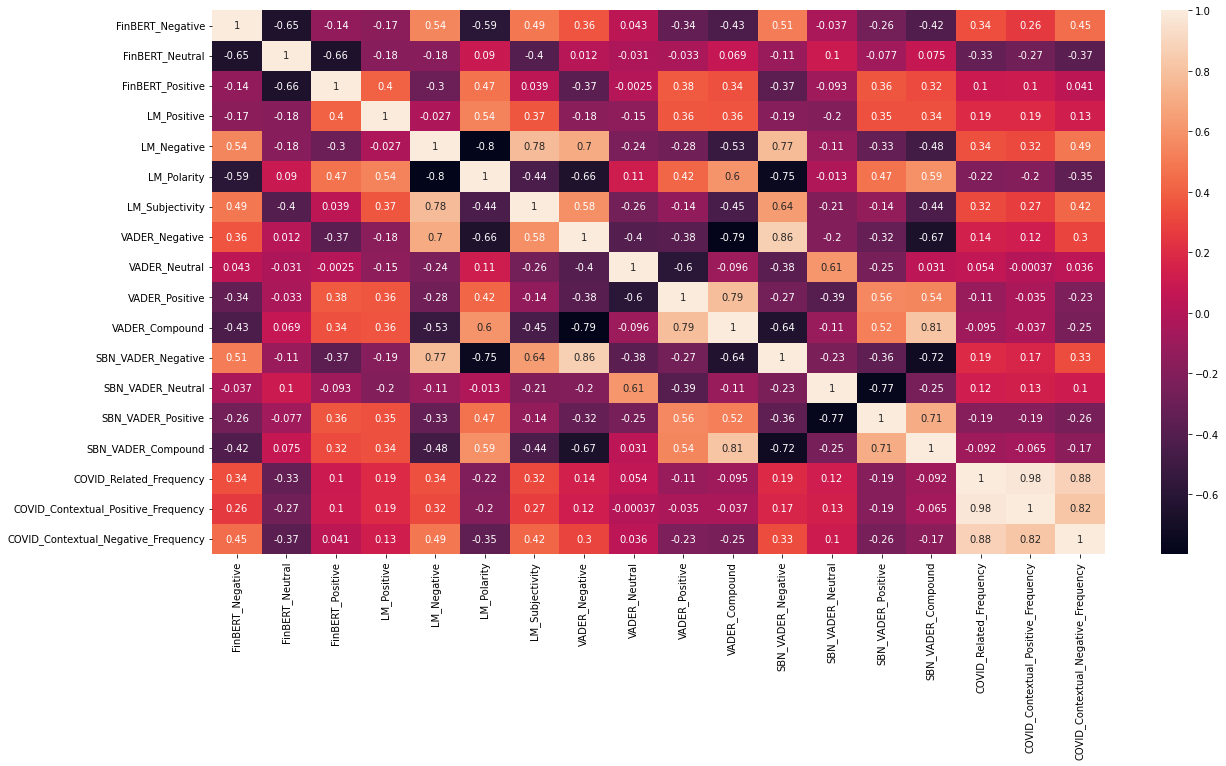

In [26]:
correlation_matrix = results_df.drop(columns="Sentence").corr()

plt.figure(figsize=(20, 10))

sns.heatmap(correlation_matrix, annot=True)

plt.show()


### Comparing sentiment score


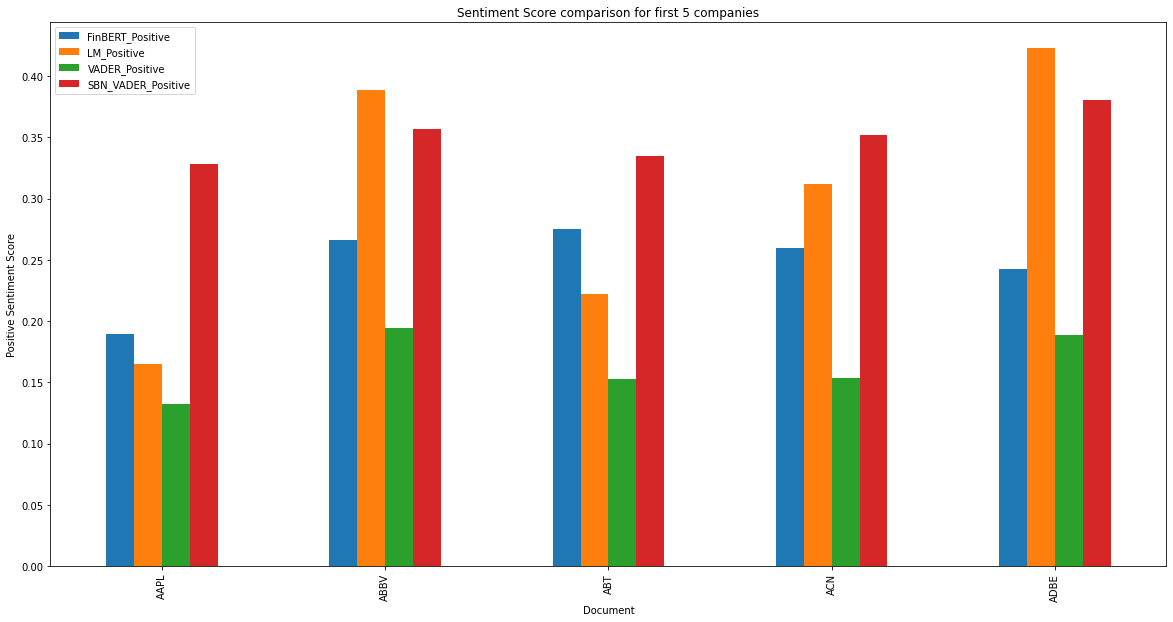

In [27]:
ax = results_df.iloc[:5].plot(
    kind="bar",
    y=["FinBERT_Positive", "LM_Positive", "VADER_Positive", "SBN_VADER_Positive"],
    figsize=(20, 10),
)
ax.set_ylabel("Positive Sentiment Score")
ax.set_title("Sentiment Score comparison for first 5 companies")
plt.show()


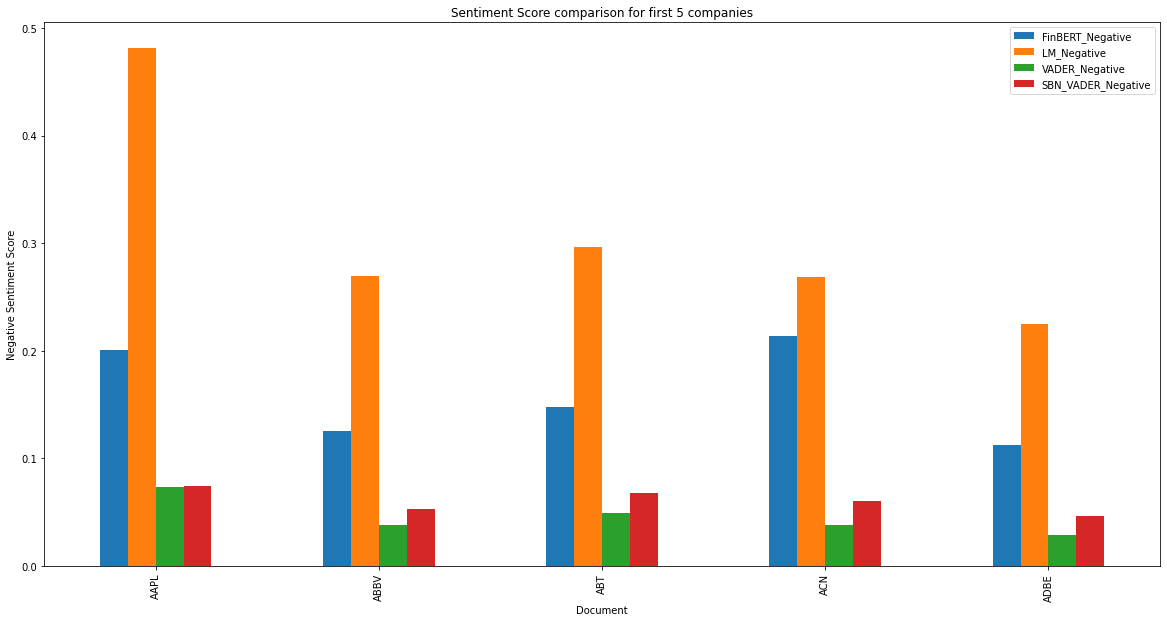

In [28]:
ax = results_df.iloc[:5].plot(
    kind="bar",
    y=["FinBERT_Negative", "LM_Negative", "VADER_Negative", "SBN_VADER_Negative"],
    figsize=(20, 10),
)
ax.set_ylabel("Negative Sentiment Score")
ax.set_title("Sentiment Score comparison for first 5 companies")
plt.show()


### Checking COVID-19 mentions

In [29]:
results_df.query("COVID_Related_Frequency == 0")

,FinBERT_Negative,FinBERT_Neutral,FinBERT_Positive,LM_Positive,LM_Negative,LM_Polarity,LM_Subjectivity,VADER_Negative,VADER_Neutral,VADER_Positive,VADER_Compound,SBN_VADER_Negative,SBN_VADER_Neutral,SBN_VADER_Positive,SBN_VADER_Compound,COVID_Related_Frequency,COVID_Contextual_Positive_Frequency,COVID_Contextual_Negative_Frequency,Sentence
Document,,,,,,,,,,,,,,,,,,,


All MD&A sections mention terms related to COVID-19.

## Comparing Stock Prices with Results from Sentiment Analysis


### Loading Stock Data


In [30]:
stock_df = pd.read_csv("./data/stock_prices.csv", parse_dates=["Date"])
stock_df

,Date,Close,Ticker
0,2020-06-01 00:00:00-04:00,218.529816,MSFT
1,2021-06-01 00:00:00-04:00,265.033173,MSFT
2,2020-06-01 00:00:00-04:00,126.193336,AAPL
3,2021-06-01 00:00:00-04:00,134.841141,AAPL
4,2020-06-01 00:00:00-04:00,133.304092,NVDA
...,...,...,...
195,2021-06-01 00:00:00-04:00,83.541824,MU
196,2020-06-01 00:00:00-04:00,57.171944,GILD
197,2021-06-01 00:00:00-04:00,61.500305,GILD
198,2020-06-01 00:00:00-04:00,45.996845,BX


### Loading Industry Data

In [31]:
ticker_data = pd.read_csv("./data/constituents.csv")

ticker_data["Symbol"] = ticker_data["Symbol"].str.replace(".", "-")

ticker_data = (
    ticker_data.set_index("Symbol").rename_axis("Ticker").join(results_df, how="inner")
)[["Name", "Sector"]].sort_index()

ticker_data


,Name,Sector
AAPL,Apple,Information Technology
ABBV,AbbVie,Health Care
ABT,Abbott Laboratories,Health Care
ACN,Accenture,Information Technology
ADBE,Adobe,Information Technology
...,...,...
UPS,United Parcel Service,Industrials
V,Visa,Information Technology
VRTX,Vertex Pharmaceuticals,Health Care
VZ,Verizon Communications,Communication Services


### Merging Datasets


In [32]:
# Calculate the yearly price change for each ticker
stock_df["Year"] = stock_df["Date"].dt.year

price_change_df = stock_df.pivot(
    index="Ticker", columns="Year", values="Close"
).pct_change(axis=1)

# Reset index and prepare for merging with the result
price_change_df = price_change_df.reset_index()
price_change_df = price_change_df.drop(columns=2020)
price_change_df.columns = ["Ticker", "Price_Change_%"]
price_change_df = price_change_df.set_index("Ticker").rename_axis("Document")

merged_df = results_df.join(price_change_df).join(ticker_data).reset_index()

merged_df

,Document,FinBERT_Negative,FinBERT_Neutral,FinBERT_Positive,LM_Positive,LM_Negative,LM_Polarity,LM_Subjectivity,VADER_Negative,VADER_Neutral,...,SBN_VADER_Neutral,SBN_VADER_Positive,SBN_VADER_Compound,COVID_Related_Frequency,COVID_Contextual_Positive_Frequency,COVID_Contextual_Negative_Frequency,Sentence,Price_Change_%,Name,Sector
0,AAPL,0.200770,0.609698,0.189531,0.165414,0.481203,-0.169925,0.035307,0.073143,0.794820,...,0.597602,0.328030,0.305426,0.045113,0.037594,0.037594,133,0.068528,Apple,Information Technology
1,ABBV,0.125290,0.608638,0.266072,0.388489,0.269784,0.068945,0.035459,0.038511,0.767079,...,0.589874,0.357345,0.357100,0.089928,0.082734,0.035971,278,0.235676,AbbVie,Health Care
2,ABT,0.147613,0.577167,0.275220,0.222222,0.296296,-0.047901,0.030115,0.049383,0.790358,...,0.589775,0.334491,0.269774,0.130864,0.101235,0.069136,405,0.074896,Abbott Laboratories,Health Care
3,ACN,0.214290,0.526049,0.259661,0.311688,0.268398,0.065656,0.038630,0.038515,0.807810,...,0.588017,0.351840,0.317782,0.060606,0.030303,0.021645,231,0.246055,Accenture,Information Technology
4,ADBE,0.112824,0.644548,0.242627,0.422819,0.224832,0.121365,0.032955,0.029131,0.781819,...,0.573094,0.380812,0.380286,0.033557,0.020134,0.023490,298,0.140731,Adobe,Information Technology
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,UPS,0.196942,0.507644,0.295414,0.349558,0.345133,-0.028857,0.036980,0.037546,0.753836,...,0.547907,0.378458,0.349425,0.055310,0.037611,0.019912,452,0.301305,United Parcel Service,Industrials
84,V,0.179173,0.697402,0.123426,0.237952,0.412651,-0.092169,0.044104,0.067554,0.783389,...,0.614880,0.307672,0.233386,0.027108,0.012048,0.006024,332,0.109635,Visa,Information Technology
85,VRTX,0.138450,0.577324,0.284225,0.401338,0.311037,0.092642,0.039203,0.037408,0.774615,...,0.537950,0.408555,0.403438,0.096990,0.070234,0.046823,299,-0.277622,Vertex Pharmaceuticals,Health Care
86,VZ,0.170879,0.583512,0.245608,0.282577,0.341142,-0.024493,0.036912,0.046382,0.785451,...,0.545549,0.384534,0.328190,0.087848,0.067350,0.048316,683,-0.013023,Verizon Communications,Communication Services


### SentiBigNomics vs. Stock Price Change


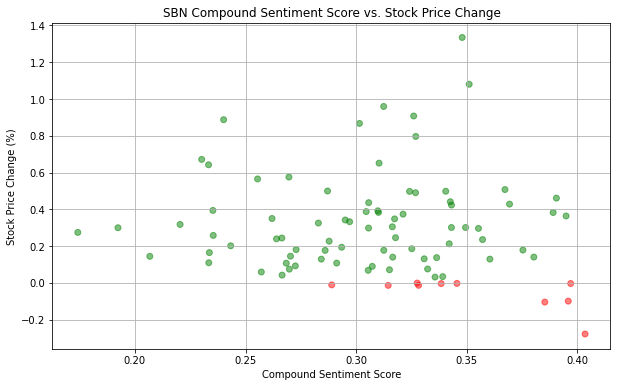

In [33]:
plt.figure(figsize=(10, 6))

# Create a color map based on the Price Change %
colors = merged_df["Price_Change_%"].apply(lambda x: "red" if x < 0 else "green")

plt.scatter(
    merged_df["SBN_VADER_Compound"],
    merged_df["Price_Change_%"],
    c=colors,
    alpha=0.5,
    label=["Negative Change", "Positive Change"],
)

plt.xlabel("Compound Sentiment Score")
plt.ylabel("Stock Price Change (%)")
plt.title("SBN Compound Sentiment Score vs. Stock Price Change")

plt.grid(True)
plt.show()

### FinBERT vs. Stock Price Change


Since most sentences have a neutral sentiment, we denote an overall document as "positive" if the average positive sentiment score is greater than the average negative sentiment score, and vice versa. We then calculate the stock price change for each ticker and compare it with the sentiment analysis results.

In [34]:
merged_df["FinBERT_Class"] = (
    merged_df[["FinBERT_Negative", "FinBERT_Positive"]]
    .idxmax(axis=1)
    .str.split("_")
    .str[1]
)

merged_df


,Document,FinBERT_Negative,FinBERT_Neutral,FinBERT_Positive,LM_Positive,LM_Negative,LM_Polarity,LM_Subjectivity,VADER_Negative,VADER_Neutral,...,SBN_VADER_Positive,SBN_VADER_Compound,COVID_Related_Frequency,COVID_Contextual_Positive_Frequency,COVID_Contextual_Negative_Frequency,Sentence,Price_Change_%,Name,Sector,FinBERT_Class
0,AAPL,0.200770,0.609698,0.189531,0.165414,0.481203,-0.169925,0.035307,0.073143,0.794820,...,0.328030,0.305426,0.045113,0.037594,0.037594,133,0.068528,Apple,Information Technology,Negative
1,ABBV,0.125290,0.608638,0.266072,0.388489,0.269784,0.068945,0.035459,0.038511,0.767079,...,0.357345,0.357100,0.089928,0.082734,0.035971,278,0.235676,AbbVie,Health Care,Positive
2,ABT,0.147613,0.577167,0.275220,0.222222,0.296296,-0.047901,0.030115,0.049383,0.790358,...,0.334491,0.269774,0.130864,0.101235,0.069136,405,0.074896,Abbott Laboratories,Health Care,Positive
3,ACN,0.214290,0.526049,0.259661,0.311688,0.268398,0.065656,0.038630,0.038515,0.807810,...,0.351840,0.317782,0.060606,0.030303,0.021645,231,0.246055,Accenture,Information Technology,Positive
4,ADBE,0.112824,0.644548,0.242627,0.422819,0.224832,0.121365,0.032955,0.029131,0.781819,...,0.380812,0.380286,0.033557,0.020134,0.023490,298,0.140731,Adobe,Information Technology,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,UPS,0.196942,0.507644,0.295414,0.349558,0.345133,-0.028857,0.036980,0.037546,0.753836,...,0.378458,0.349425,0.055310,0.037611,0.019912,452,0.301305,United Parcel Service,Industrials,Positive
84,V,0.179173,0.697402,0.123426,0.237952,0.412651,-0.092169,0.044104,0.067554,0.783389,...,0.307672,0.233386,0.027108,0.012048,0.006024,332,0.109635,Visa,Information Technology,Negative
85,VRTX,0.138450,0.577324,0.284225,0.401338,0.311037,0.092642,0.039203,0.037408,0.774615,...,0.408555,0.403438,0.096990,0.070234,0.046823,299,-0.277622,Vertex Pharmaceuticals,Health Care,Positive
86,VZ,0.170879,0.583512,0.245608,0.282577,0.341142,-0.024493,0.036912,0.046382,0.785451,...,0.384534,0.328190,0.087848,0.067350,0.048316,683,-0.013023,Verizon Communications,Communication Services,Positive


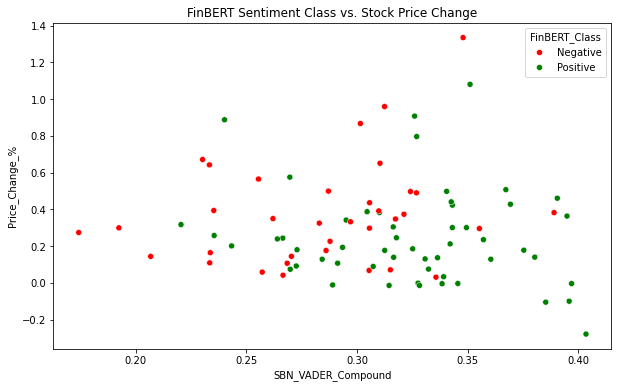

In [38]:
# TODO: FIX PLOT 

plt.figure(figsize=(10, 6))

sns.scatterplot(
    data=merged_df,
    x="SBN_VADER_Compound",
    y="Price_Change_%",
    hue="FinBERT_Class",
    palette={"Positive": "green", "Negative": "red"},
)

plt.title("FinBERT Sentiment Class vs. Stock Price Change")
plt.show()


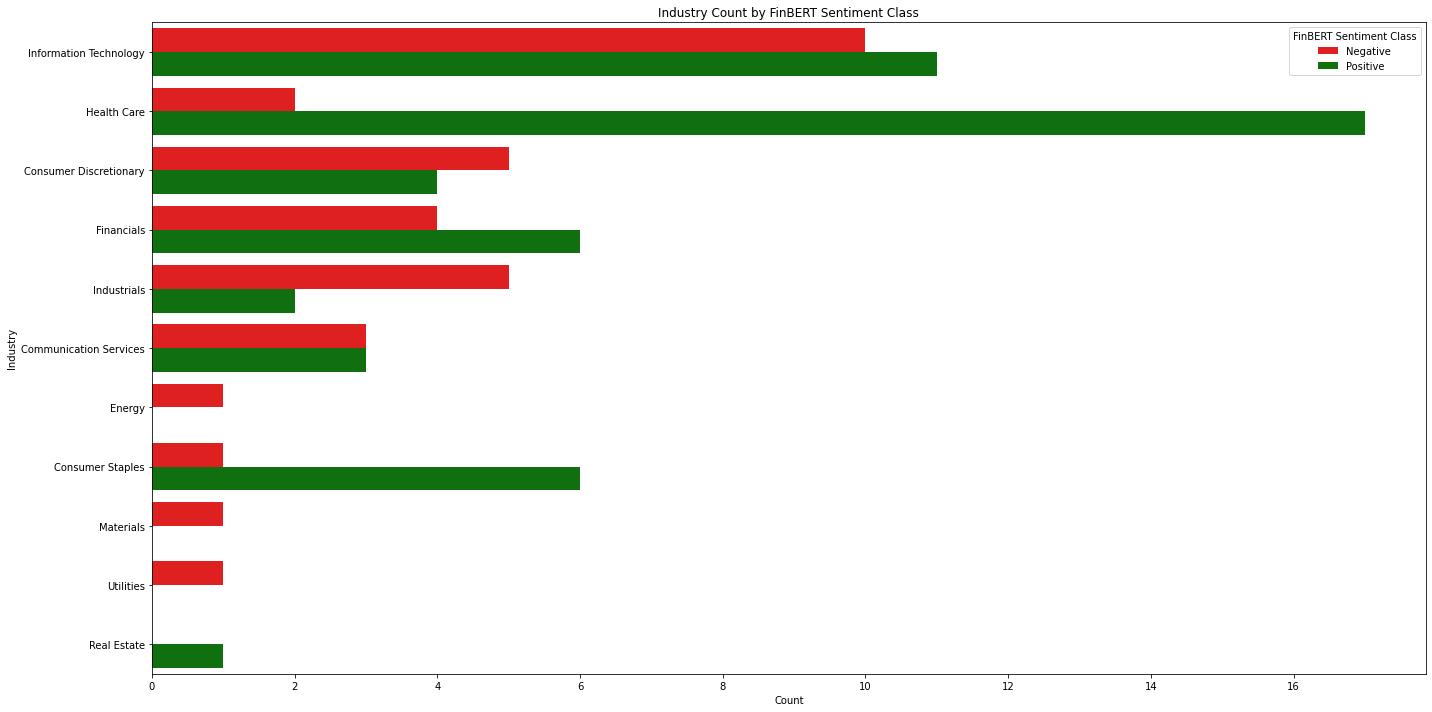

In [36]:
industry_count = (
    merged_df.groupby("FinBERT_Class")["Sector"].value_counts().to_frame().reset_index()
)

plt.figure(figsize=(20, 10))
sns.countplot(
    data=merged_df,
    y="Sector",
    hue="FinBERT_Class",
    palette={"Negative": "red", "Positive": "green"},
)

plt.title("Industry Count by FinBERT Sentiment Class")
plt.ylabel("Industry")
plt.xlabel("Count")
plt.legend(title="FinBERT Sentiment Class")

plt.tight_layout()
plt.show()
